Epoch 1/20, Loss: 0.15975238964892924
Epoch 2/20, Loss: 0.037096570789193116
Epoch 3/20, Loss: 0.03475781468053659
Epoch 4/20, Loss: 0.03317940660053864
Epoch 5/20, Loss: 0.03190313964538897
Epoch 6/20, Loss: 0.030710713588632643
Epoch 7/20, Loss: 0.029724447522312403
Epoch 8/20, Loss: 0.028878890657021355
Epoch 9/20, Loss: 0.028270068073955674
Epoch 10/20, Loss: 0.027709327715759475
Epoch 11/20, Loss: 0.026427713736969356
Epoch 12/20, Loss: 0.025738909471935283
Epoch 13/20, Loss: 0.024530794510307413
Epoch 14/20, Loss: 0.023772620848224808
Epoch 15/20, Loss: 0.022974255320150405
Epoch 16/20, Loss: 0.022067355127849925
Epoch 17/20, Loss: 0.021002588570506003
Epoch 18/20, Loss: 0.020183329111508403
Epoch 19/20, Loss: 0.019354345597093925
Epoch 20/20, Loss: 0.019009016890777275
R-squared: 0.441832849411089


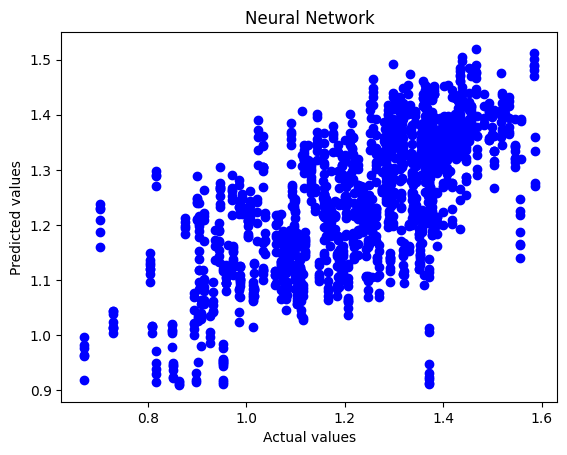

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Importing the dataset from Excel
dataset = pd.read_excel('dates.xlsx')

# Assuming the target variable is in the last column
X = dataset.iloc[:, 1:8].values
y = dataset.iloc[:, -1].values

# Apply one-hot encoding to specific columns (if needed)
# In this example, assuming one-hot encoding for the third column (index 2)
column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), [3])  # Assuming one-hot encoding for the third column (index 2)
    ],
    remainder='passthrough'
)

X = column_transformer.fit_transform(X)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Feature Scaling (not necessary for neural networks, but can be applied)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create a PyTorch dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Instantiate the model and define the loss function and optimizer
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    test_loss = criterion(y_pred_tensor, y_test_tensor)

# Convert predictions back to NumPy arrays
y_pred = y_pred_tensor.numpy()
y_test_np = y_test_tensor.numpy()

# Evaluate the Model Performance
r2 = r2_score(y_test_np, y_pred)
print(f'R-squared: {r2}')

# Plotting the results (optional)
plt.scatter(y_test, y_pred, color='blue')
plt.title('Neural Network')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()
